## Imports 

In [625]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import iqr
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import pickle
import json
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [626]:
data = pd.read_csv('./survey_results_public.csv')

## Data exploration, Cleaning & Preprocessing

In [628]:
data.shape

(89184, 84)

In [629]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89184 entries, 0 to 89183
Data columns (total 84 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ResponseId                           89184 non-null  int64  
 1   Q120                                 89184 non-null  object 
 2   MainBranch                           89184 non-null  object 
 3   Age                                  89184 non-null  object 
 4   Employment                           87898 non-null  object 
 5   RemoteWork                           73810 non-null  object 
 6   CodingActivities                     73764 non-null  object 
 7   EdLevel                              87973 non-null  object 
 8   LearnCode                            87663 non-null  object 
 9   LearnCodeOnline                      70084 non-null  object 
 10  LearnCodeCoursesCert                 37076 non-null  object 
 11  YearsCode                   

In [630]:
data = data.drop(['ResponseId', 'Q120'], axis=1)

### taking only non CovertedCompYearly values

In [632]:
data = data[data["ConvertedCompYearly"].notnull()]

In [633]:
data.shape

(48019, 82)

### Turning to numeric values

In [635]:
data[['YearsCode', 'YearsCodePro']] = data[['YearsCode', 'YearsCodePro']].apply(pd.to_numeric, errors='coerce')

### Taking missing percentage threshold

In [637]:
missing_percentage_per_row = data.isnull().sum(axis=1) / data.shape[1]

# Count rows with more than 50% missing values
rows_with_high_missing = missing_percentage_per_row[missing_percentage_per_row >= 0.8]

# Print the count
print("Number of rows with more than 80% missing values:", len(rows_with_high_missing))

Number of rows with more than 80% missing values: 1


### Row wise

In [639]:
data = data[missing_percentage_per_row < 0.5]

In [640]:
data.shape

(45661, 82)

### Column wise

In [642]:
missing_values = data.isnull().mean() * 100
print(missing_values)

# Drop columns with more than a threshold (e.g., 80%) of missing values
threshold = 80
columns_to_drop = missing_values[missing_values > threshold].index
data = data.drop(columns_to_drop, axis=1)

MainBranch              0.000000
Age                     0.000000
Employment              0.021901
RemoteWork              0.113883
CodingActivities        0.155494
                         ...    
ProfessionalTech       30.533716
Industry               39.250126
SurveyLength            0.928582
SurveyEase              0.840980
ConvertedCompYearly     0.000000
Length: 82, dtype: float64


In [643]:
data.shape

(45661, 78)

### Selected columns cleaning

In [645]:
mandatory_columns1 = ['DevType', 'Industry', 'EdLevel', 'Age', 'Country', 'ProfessionalTech','WorkExp','YearsCodePro','LanguageHaveWorkedWith','RemoteWork','Employment','ToolsTechHaveWorkedWith','DatabaseHaveWorkedWith','WebframeHaveWorkedWith']

# Drop rows where any of the mandatory columns have null values
data = data.dropna(subset=mandatory_columns1)

In [646]:
print(data[mandatory_columns1].isnull().sum())

DevType                    0
Industry                   0
EdLevel                    0
Age                        0
Country                    0
ProfessionalTech           0
WorkExp                    0
YearsCodePro               0
LanguageHaveWorkedWith     0
RemoteWork                 0
Employment                 0
ToolsTechHaveWorkedWith    0
DatabaseHaveWorkedWith     0
WebframeHaveWorkedWith     0
dtype: int64


### Dropping columns

In [648]:
data.drop(columns=['YearsCode'], inplace=True)
data.drop(columns=['CompTotal'], inplace=True)
data.drop(columns=['Currency'], inplace=True)

### Outlier checking and removing

In [650]:
# List of columns to check for outliers
columns_to_check = ['WorkExp', 'YearsCodePro','ConvertedCompYearly']

# Create a copy of the original DataFrame to keep track of the original shape
original_shape = data.shape

# Initialize a mask for rows to drop with the same index as the DataFrame
mask_to_drop = pd.Series([False] * len(data), index=data.index)

# Loop through each specified column and identify outliers
for col in columns_to_check:
    # Calculate Q1 and Q3 for the current column
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    
    # Calculate the IQR for the current column
    IQR = Q3 - Q1
    
    # Update the mask to mark outliers for the current column
    mask_to_drop |= (data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))

# Drop the outliers from the original DataFrame
data = data[~mask_to_drop]

In [651]:
data.shape

(17728, 75)

### Numerical and categorical categorization

In [653]:
numerical_columns = data.select_dtypes(include=[float, int]).columns.tolist()
print("Numerical Columns:\n", numerical_columns)

# Identify categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns
print("Categorical Columns:\n", categorical_columns)

Numerical Columns:
 ['YearsCodePro', 'WorkExp', 'ConvertedCompYearly']
Categorical Columns:
 Index(['MainBranch', 'Age', 'Employment', 'RemoteWork', 'CodingActivities',
       'EdLevel', 'LearnCode', 'LearnCodeOnline', 'LearnCodeCoursesCert',
       'DevType', 'OrgSize', 'PurchaseInfluence', 'TechList', 'BuyNewTool',
       'Country', 'LanguageHaveWorkedWith', 'LanguageWantToWorkWith',
       'DatabaseHaveWorkedWith', 'DatabaseWantToWorkWith',
       'PlatformHaveWorkedWith', 'PlatformWantToWorkWith',
       'WebframeHaveWorkedWith', 'WebframeWantToWorkWith',
       'MiscTechHaveWorkedWith', 'MiscTechWantToWorkWith',
       'ToolsTechHaveWorkedWith', 'ToolsTechWantToWorkWith',
       'NEWCollabToolsHaveWorkedWith', 'NEWCollabToolsWantToWorkWith',
       'OpSysPersonal use', 'OpSysProfessional use',
       'OfficeStackAsyncHaveWorkedWith', 'OfficeStackAsyncWantToWorkWith',
       'OfficeStackSyncHaveWorkedWith', 'OfficeStackSyncWantToWorkWith',
       'AISearchHaveWorkedWith', 'AISearch

### Corealtion matrix

In [655]:
target_column = 'ConvertedCompYearly'  

# Ensure target column is included in the numerical columns list
if target_column not in numerical_columns:
    numerical_columns.append(target_column)

# Calculate the correlation matrix
correlation_matrix = data[numerical_columns].corr()
print("Correlation Matrix:\n", correlation_matrix)

# Extract correlation with the target variable
target_corr = correlation_matrix[target_column].abs().sort_values(ascending=False)
print("Correlation with Target Variable:\n", target_corr)

# Set a threshold for correlation
threshold = 0.1 # Adjust this value as needed

# Select features with correlation higher than the threshold
important_numerical_features = target_corr[target_corr > threshold].index

# Drop the target column from the list of important features if needed
if target_column in important_numerical_features:
    important_numerical_features = important_numerical_features.drop(target_column)

print("Important Numerical Features:\n", important_numerical_features)

Correlation Matrix:
                      YearsCodePro   WorkExp  ConvertedCompYearly
YearsCodePro             1.000000  0.917913             0.360673
WorkExp                  0.917913  1.000000             0.355707
ConvertedCompYearly      0.360673  0.355707             1.000000
Correlation with Target Variable:
 ConvertedCompYearly    1.000000
YearsCodePro           0.360673
WorkExp                0.355707
Name: ConvertedCompYearly, dtype: float64
Important Numerical Features:
 Index(['YearsCodePro', 'WorkExp'], dtype='object')


### Content preprocessing

In [657]:
for col in categorical_columns:
    data[col] = data[col].str.strip().str.lower()

### Checking for null

In [659]:
for col in data :
  print(f'{col}\t\t{data[col].isna().sum()}')

MainBranch		0
Age		0
Employment		0
RemoteWork		0
CodingActivities		2
EdLevel		0
LearnCode		23
LearnCodeOnline		3041
LearnCodeCoursesCert		9172
YearsCodePro		0
DevType		0
OrgSize		6
PurchaseInfluence		3
TechList		5821
BuyNewTool		339
Country		0
LanguageHaveWorkedWith		0
LanguageWantToWorkWith		889
DatabaseHaveWorkedWith		0
DatabaseWantToWorkWith		2171
PlatformHaveWorkedWith		2250
PlatformWantToWorkWith		4602
WebframeHaveWorkedWith		0
WebframeWantToWorkWith		2048
MiscTechHaveWorkedWith		4793
MiscTechWantToWorkWith		6661
ToolsTechHaveWorkedWith		0
ToolsTechWantToWorkWith		1605
NEWCollabToolsHaveWorkedWith		36
NEWCollabToolsWantToWorkWith		1498
OpSysPersonal use		82
OpSysProfessional use		855
OfficeStackAsyncHaveWorkedWith		1256
OfficeStackAsyncWantToWorkWith		4292
OfficeStackSyncHaveWorkedWith		142
OfficeStackSyncWantToWorkWith		2449
AISearchHaveWorkedWith		6009
AISearchWantToWorkWith		7852
AIDevHaveWorkedWith		11460
AIDevWantToWorkWith		12834
NEWSOSites		0
SOVisitFreq		33
SOAccount		1
SO

In [660]:
def fill_categorical_target(df, column_name, target_column):
    # Calculate the mean of the target variable for each category
    means = df.groupby(column_name)[target_column].mean()
    
    # Fill null values in the categorical column with the mean of the target for that category
    df[column_name] = df[column_name].fillna(df[column_name].map(means))
    
    # Fallback: Fill remaining nulls with mode of the column
    mode_value = df[column_name].mode()[0]
    df[column_name].fillna(mode_value, inplace=True)

target_column = 'ConvertedCompYearly'  # Your target column

for col in categorical_columns:
    print(f"Processing categorical column: {col}")
    fill_categorical_target(data, col, target_column)

Processing categorical column: MainBranch
Processing categorical column: Age
Processing categorical column: Employment
Processing categorical column: RemoteWork
Processing categorical column: CodingActivities
Processing categorical column: EdLevel
Processing categorical column: LearnCode
Processing categorical column: LearnCodeOnline
Processing categorical column: LearnCodeCoursesCert
Processing categorical column: DevType
Processing categorical column: OrgSize
Processing categorical column: PurchaseInfluence
Processing categorical column: TechList
Processing categorical column: BuyNewTool


C:\Users\user\AppData\Local\Temp\ipykernel_7572\1485541225.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_name].fillna(mode_value, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_7572\1485541225.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

Processing categorical column: Country
Processing categorical column: LanguageHaveWorkedWith
Processing categorical column: LanguageWantToWorkWith
Processing categorical column: DatabaseHaveWorkedWith
Processing categorical column: DatabaseWantToWorkWith
Processing categorical column: PlatformHaveWorkedWith
Processing categorical column: PlatformWantToWorkWith


C:\Users\user\AppData\Local\Temp\ipykernel_7572\1485541225.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_name].fillna(mode_value, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_7572\1485541225.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

Processing categorical column: WebframeHaveWorkedWith
Processing categorical column: WebframeWantToWorkWith
Processing categorical column: MiscTechHaveWorkedWith
Processing categorical column: MiscTechWantToWorkWith
Processing categorical column: ToolsTechHaveWorkedWith
Processing categorical column: ToolsTechWantToWorkWith
Processing categorical column: NEWCollabToolsHaveWorkedWith
Processing categorical column: NEWCollabToolsWantToWorkWith
Processing categorical column: OpSysPersonal use
Processing categorical column: OpSysProfessional use
Processing categorical column: OfficeStackAsyncHaveWorkedWith


C:\Users\user\AppData\Local\Temp\ipykernel_7572\1485541225.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_name].fillna(mode_value, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_7572\1485541225.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

Processing categorical column: OfficeStackAsyncWantToWorkWith
Processing categorical column: OfficeStackSyncHaveWorkedWith
Processing categorical column: OfficeStackSyncWantToWorkWith
Processing categorical column: AISearchHaveWorkedWith
Processing categorical column: AISearchWantToWorkWith
Processing categorical column: AIDevHaveWorkedWith
Processing categorical column: AIDevWantToWorkWith
Processing categorical column: NEWSOSites
Processing categorical column: SOVisitFreq
Processing categorical column: SOAccount
Processing categorical column: SOPartFreq
Processing categorical column: SOComm
Processing categorical column: SOAI
Processing categorical column: AISelect
Processing categorical column: AISent


C:\Users\user\AppData\Local\Temp\ipykernel_7572\1485541225.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_name].fillna(mode_value, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_7572\1485541225.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

Processing categorical column: AIAcc
Processing categorical column: AIBen
Processing categorical column: AIToolInterested in Using
Processing categorical column: AIToolCurrently Using
Processing categorical column: AIToolNot interested in Using
Processing categorical column: AINextSomewhat different
Processing categorical column: TBranch
Processing categorical column: ICorPM
Processing categorical column: Knowledge_1
Processing categorical column: Knowledge_2
Processing categorical column: Knowledge_3
Processing categorical column: Knowledge_4
Processing categorical column: Knowledge_5
Processing categorical column: Knowledge_6
Processing categorical column: Knowledge_7
Processing categorical column: Knowledge_8
Processing categorical column: Frequency_1
Processing categorical column: Frequency_2
Processing categorical column: Frequency_3
Processing categorical column: TimeSearching
Processing categorical column: TimeAnswering
Processing categorical column: ProfessionalTech
Processing 

C:\Users\user\AppData\Local\Temp\ipykernel_7572\1485541225.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column_name].fillna(mode_value, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_7572\1485541225.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [661]:
for col in data :
  print(f'{col}\t\t{data[col].isna().sum()}')

MainBranch		0
Age		0
Employment		0
RemoteWork		0
CodingActivities		0
EdLevel		0
LearnCode		0
LearnCodeOnline		0
LearnCodeCoursesCert		0
YearsCodePro		0
DevType		0
OrgSize		0
PurchaseInfluence		0
TechList		0
BuyNewTool		0
Country		0
LanguageHaveWorkedWith		0
LanguageWantToWorkWith		0
DatabaseHaveWorkedWith		0
DatabaseWantToWorkWith		0
PlatformHaveWorkedWith		0
PlatformWantToWorkWith		0
WebframeHaveWorkedWith		0
WebframeWantToWorkWith		0
MiscTechHaveWorkedWith		0
MiscTechWantToWorkWith		0
ToolsTechHaveWorkedWith		0
ToolsTechWantToWorkWith		0
NEWCollabToolsHaveWorkedWith		0
NEWCollabToolsWantToWorkWith		0
OpSysPersonal use		0
OpSysProfessional use		0
OfficeStackAsyncHaveWorkedWith		0
OfficeStackAsyncWantToWorkWith		0
OfficeStackSyncHaveWorkedWith		0
OfficeStackSyncWantToWorkWith		0
AISearchHaveWorkedWith		0
AISearchWantToWorkWith		0
AIDevHaveWorkedWith		0
AIDevWantToWorkWith		0
NEWSOSites		0
SOVisitFreq		0
SOAccount		0
SOPartFreq		0
SOComm		0
SOAI		0
AISelect		0
AISent		0
AIAcc		0
AIBen		

### Scaling numerical columns

In [663]:
data["YearsCodePro"].unique()

array([ 4., 21.,  3.,  9.,  7., 10.,  6., 14.,  2., 15., 28., 11.,  8.,
        5., 17., 16., 12., 20.,  1., 25., 22., 13., 23., 24., 27., 19.,
       26., 18.])

In [664]:
data["WorkExp"].unique()

array([ 6., 22.,  4.,  5.,  9.,  7., 15., 14., 18., 28., 12.,  3., 17.,
       10., 16., 11.,  2., 25.,  8., 20.,  1., 13., 30., 21., 23., 27.,
       26., 19., 24., 29.,  0.])

In [665]:
print(data["WorkExp"].min())
print(data["WorkExp"].max())
print(data["YearsCodePro"].min())
print(data["YearsCodePro"].max())

0.0
30.0
1.0
28.0


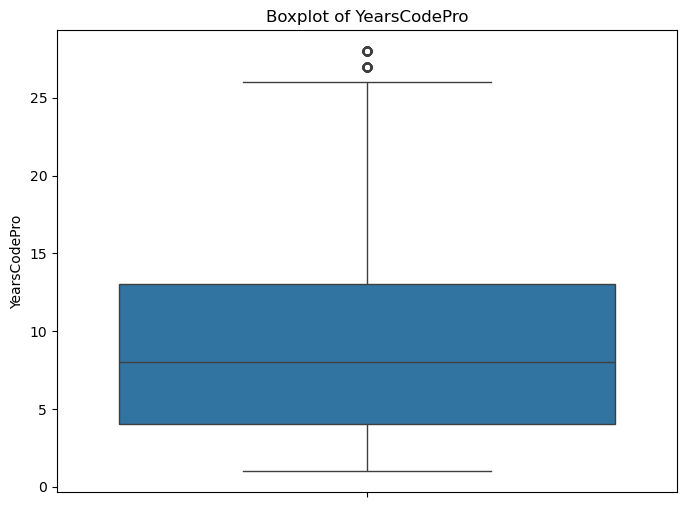

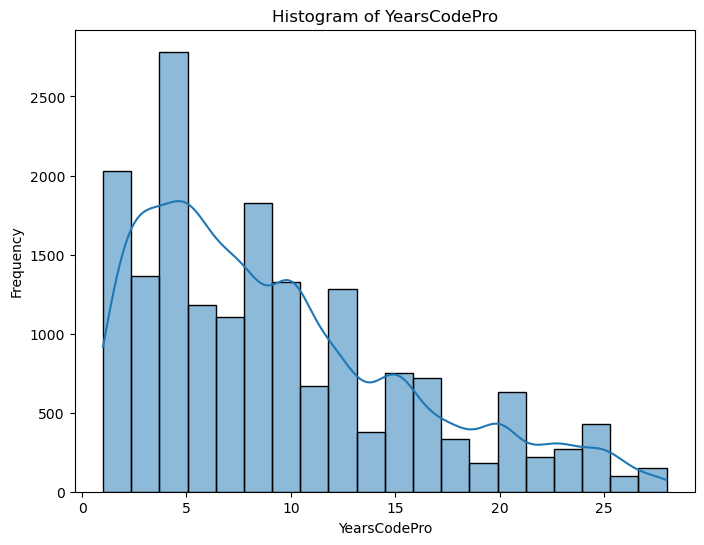

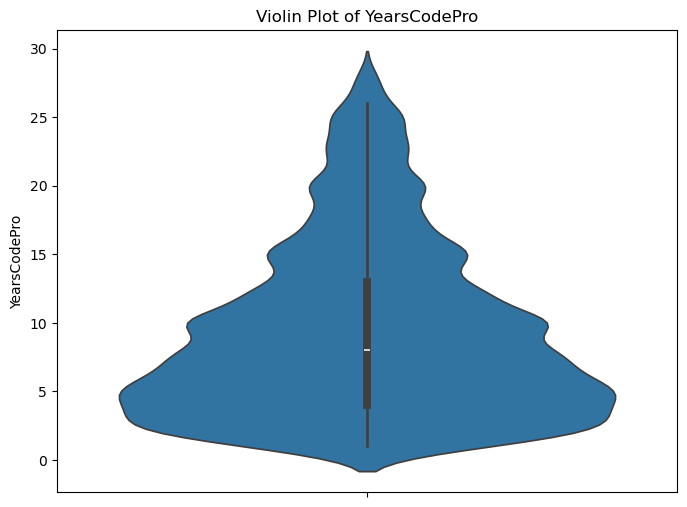

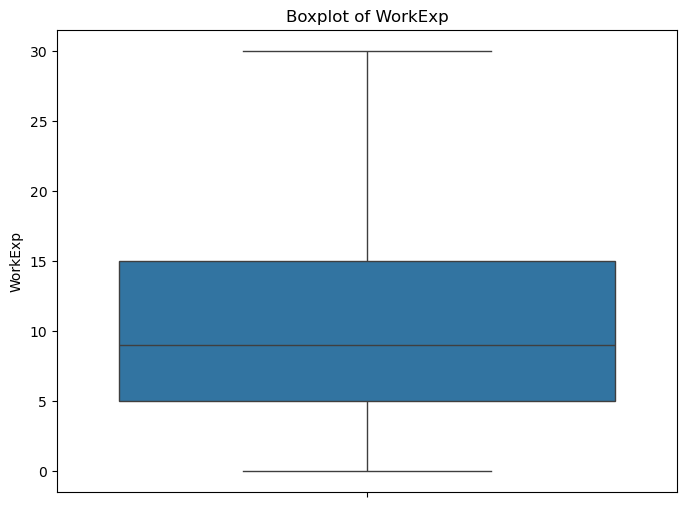

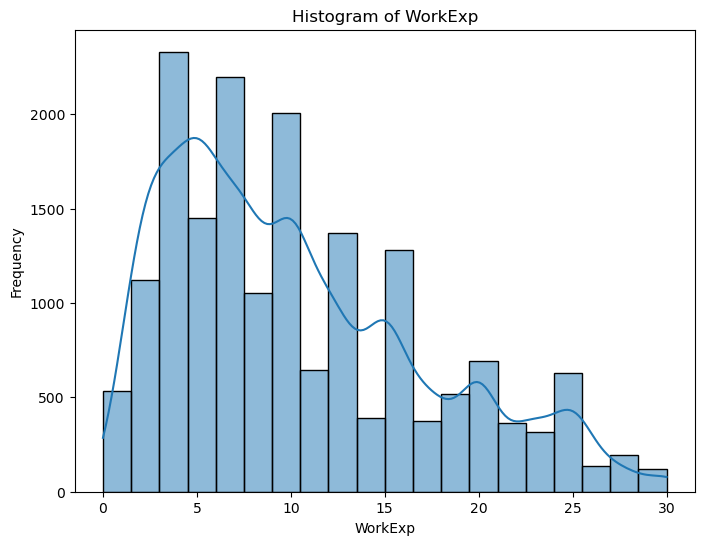

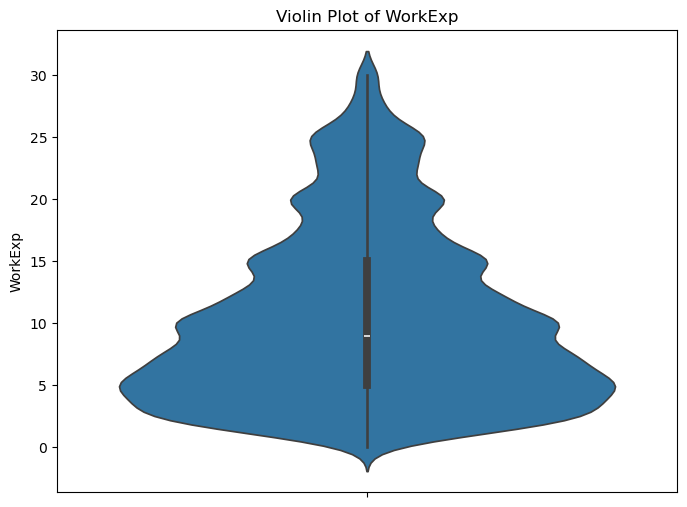

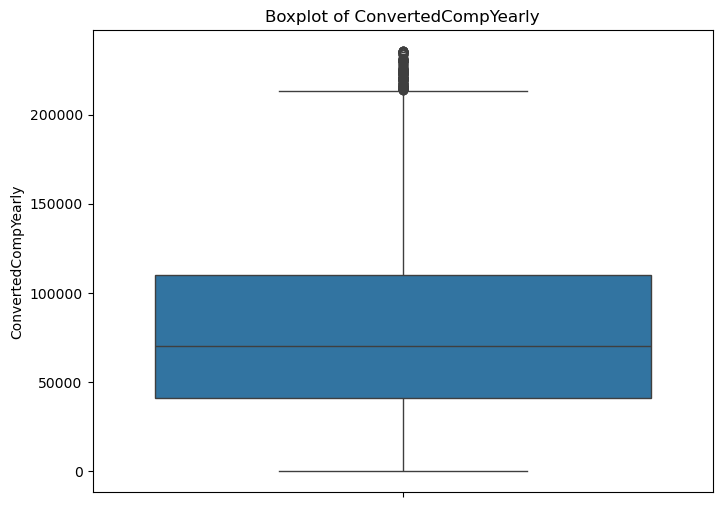

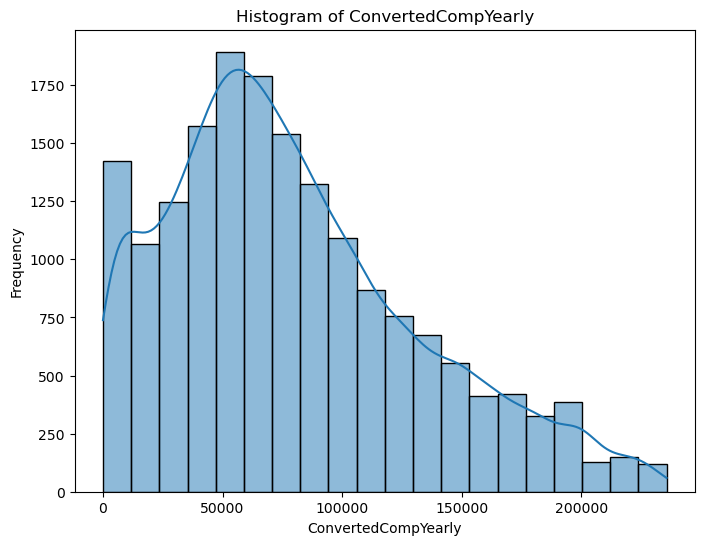

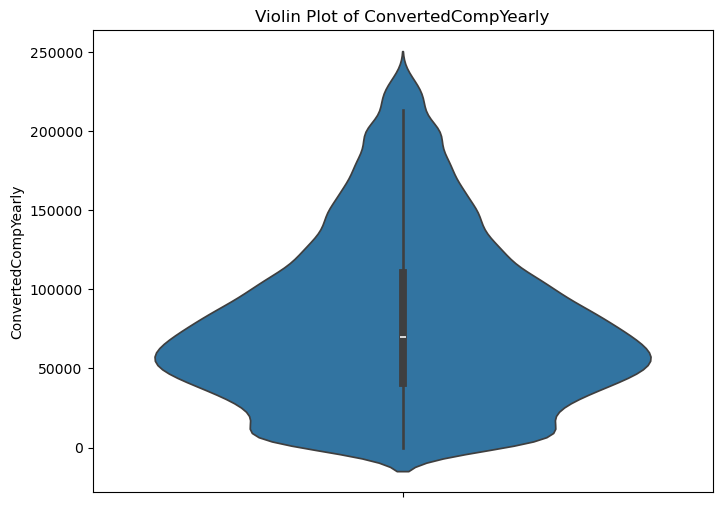

In [666]:
# Generate Box Plot, Histogram, Violin Plot, and Scatter Plot for each numerical column
for col in numerical_columns:
    # Box Plot
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=data[col])
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
    plt.show()

    # Histogram
    plt.figure(figsize=(8, 6))
    sns.histplot(data[col], bins=20, kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

    # Violin Plot
    plt.figure(figsize=(8, 6))
    sns.violinplot(y=data[col])
    plt.title(f'Violin Plot of {col}')
    plt.ylabel(col)
    plt.show()

In [667]:
scaler = MinMaxScaler()
columns_to_scale = ['YearsCodePro', 'WorkExp']

# Apply the scaler only to the columns in columns_to_scale
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

### Selecting countries with certain value counts

In [669]:
def shorten_categories(categories, cutoff):
    categorical_map = {}
    for i in range(len(categories)):
        if categories.values[i] >= cutoff:
            categorical_map[categories.index[i]] = categories.index[i]
        else:
            categorical_map[categories.index[i]] = 'Other'
    return categorical_map

In [670]:
country_map = shorten_categories(data.Country.value_counts(), 400)
data['Country'] = data['Country'].map(country_map)

### Educationa column preprocessing

In [672]:
def clean_education(x):
    if 'associate degree (a.a., a.s., etc.)' in x:
        return 'Associate degree'
    if 'bachelor’s degree (b.a., b.s., b.eng., etc.)' in x:
        return 'Bachelor’s degree'
    if 'master’s degree (m.a., m.s., m.eng., mba, etc.)' in x:
        return 'Master’s degree'
    if 'some college/university study without earning a degree' in x:
        return 'Some college/university study without earning a degree'   
    if 'secondary school (e.g. american high school, german realschule or gymnasium, etc.)' in x:
        return 'Secondary school'  
    if 'primary/elementary school' in x:
        return 'Primary/elementary school'  
    if 'professional degree (jd, md, ph.d, ed.d, etc.)' in x:
        return 'Professional degree'  
    return 'Less than a Bachelors'

# Apply the cleaning function to the 'EdLevel' column
data["EdLevel"] = data["EdLevel"].apply(clean_education)


In [673]:
# Get the unique value names in the 'EdLevel' column
unique_value_names = data['EdLevel'].unique()

# Get the counts of each unique value in the 'EdLevel' column
value_counts = data['EdLevel'].value_counts()

# Print the real names of the unique values (distinct values)
print("Unique Value Names in 'EdLevel':\n", unique_value_names)

# Print the counts of each unique value
print("\nCount of each unique value in 'EdLevel':\n", value_counts)


Unique Value Names in 'EdLevel':
 ['Bachelor’s degree'
 'Some college/university study without earning a degree'
 'Master’s degree' 'Associate degree' 'Secondary school'
 'Primary/elementary school' 'Professional degree' 'Less than a Bachelors']

Count of each unique value in 'EdLevel':
 EdLevel
Bachelor’s degree                                         8842
Master’s degree                                           4436
Some college/university study without earning a degree    2148
Secondary school                                           869
Associate degree                                           626
Professional degree                                        544
Less than a Bachelors                                      185
Primary/elementary school                                   78
Name: count, dtype: int64


In [687]:
data["EdLevel"]

4                                        Bachelor’s degree
5        Some college/university study without earning ...
6        Some college/university study without earning ...
7                                        Bachelor’s degree
12                                       Bachelor’s degree
                               ...                        
89152                                    Bachelor’s degree
89160                                  Professional degree
89166    Some college/university study without earning ...
89167                                    Bachelor’s degree
89170                                      Master’s degree
Name: EdLevel, Length: 17728, dtype: object

### Other column criterias

In [532]:
data=data[data['ConvertedCompYearly'] >= 10000]
data=data[data['Country'] != 'Other']

In [533]:
data = data[~data["DevType"].isin(["Other (please specify):", "Engineering manager","Academic researcher","Senior Executive (C-Suite, VP, etc.)","Security professional","Scientist","Product manager","Educator","Marketing or sales professional","Student"])]

In [534]:
data.shape

(10661, 75)

### 'Other' Grouping

In [536]:
# Define a threshold for rare categories
threshold = 20 # Categories with fewer than 20 occurrences will be grouped as 'Other'

# Iterate through each categorical column
for column in categorical_columns:
    # Get the frequency of each category
    value_counts = data[column].value_counts()
    
    # Identify categories that appear less than the threshold
    rare_categories = value_counts[value_counts < threshold].index
    
    # Replace rare categories with 'Other'
    data[column] = data[column].replace(rare_categories, 'Other')

print("Updated Data with Rare Categories Grouped as 'Other':\n", data.head())

Updated Data with Rare Categories Grouped as 'Other':
                         MainBranch              Age           Employment  \
5   i am a developer by profession  35-44 years old  employed, full-time   
6   i am a developer by profession  35-44 years old  employed, full-time   
7   i am a developer by profession  25-34 years old  employed, full-time   
12  i am a developer by profession  25-34 years old  employed, full-time   
14  i am a developer by profession  25-34 years old  employed, full-time   

                              RemoteWork  \
5                                 remote   
6                                 remote   
7                                 remote   
12                                remote   
14  hybrid (some remote, some in-person)   

                                     CodingActivities  \
5   hobby;professional development or self-paced l...   
6   hobby;contribute to open-source projects;profe...   
7                                               hobb

### Encoding

In [538]:
numerical_columns = data.select_dtypes(include=[float, int]).columns.tolist()
print("Numerical Columns:\n", numerical_columns)

# Identify categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns
print("Categorical Columns:\n", categorical_columns)

Numerical Columns:
 ['YearsCodePro', 'WorkExp', 'ConvertedCompYearly']
Categorical Columns:
 Index(['MainBranch', 'Age', 'Employment', 'RemoteWork', 'CodingActivities',
       'EdLevel', 'LearnCode', 'LearnCodeOnline', 'LearnCodeCoursesCert',
       'DevType', 'OrgSize', 'PurchaseInfluence', 'TechList', 'BuyNewTool',
       'Country', 'LanguageHaveWorkedWith', 'LanguageWantToWorkWith',
       'DatabaseHaveWorkedWith', 'DatabaseWantToWorkWith',
       'PlatformHaveWorkedWith', 'PlatformWantToWorkWith',
       'WebframeHaveWorkedWith', 'WebframeWantToWorkWith',
       'MiscTechHaveWorkedWith', 'MiscTechWantToWorkWith',
       'ToolsTechHaveWorkedWith', 'ToolsTechWantToWorkWith',
       'NEWCollabToolsHaveWorkedWith', 'NEWCollabToolsWantToWorkWith',
       'OpSysPersonal use', 'OpSysProfessional use',
       'OfficeStackAsyncHaveWorkedWith', 'OfficeStackAsyncWantToWorkWith',
       'OfficeStackSyncHaveWorkedWith', 'OfficeStackSyncWantToWorkWith',
       'AISearchHaveWorkedWith', 'AISearch

### Categorical

In [540]:
label_encoder = LabelEncoder()

# Dictionary to store mappings for each categorical column
label_mappings = {}

for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])
    
    # Save the mapping (original category -> label)
    label_mappings[col] = {index: label for index, label in enumerate(label_encoder.classes_)}

# Print the saved mappings
(label_mappings)

{'MainBranch': {0: 'i am a developer by profession',
  1: 'i am not primarily a developer, but i write code sometimes as part of my work/studies'},
 'Age': {0: '18-24 years old',
  1: '25-34 years old',
  2: '35-44 years old',
  3: '45-54 years old',
  4: '55-64 years old',
  5: 'Other'},
 'Employment': {0: 'Other',
  1: 'employed, full-time',
  2: 'employed, full-time;employed, part-time',
  3: 'employed, full-time;independent contractor, freelancer, or self-employed',
  4: 'employed, part-time',
  5: 'independent contractor, freelancer, or self-employed',
  6: 'independent contractor, freelancer, or self-employed;employed, part-time'},
 'RemoteWork': {0: 'hybrid (some remote, some in-person)',
  1: 'in-person',
  2: 'remote'},
 'CodingActivities': {0: 'Other',
  1: 'bootstrapping a business',
  2: 'bootstrapping a business;freelance/contract work',
  3: 'bootstrapping a business;professional development or self-paced learning from online courses',
  4: 'bootstrapping a business;profe

In [541]:
# Save label_mappings to a JSON file
with open('label_mappings.json', 'w') as json_file:
    json.dump(label_mappings, json_file, indent=4)

print("Mappings saved to label_mappings.json")

Mappings saved to label_mappings.json


###  Selecting effective features

In [543]:
target_variable = 'ConvertedCompYearly'

# Compute the correlation matrix
correlation_matrix = data.corr()

# Extract correlation with the target variable
target_correlation = correlation_matrix[target_variable]

# Sorting
sorted_correlation = target_correlation.abs().sort_values(ascending=False)

#  Optionally set a threshold for strong correlation
threshold = 0.01
effective_features = sorted_correlation[sorted_correlation > threshold]

# Display the most effective features
print("Most Effective Features:\n", effective_features)

Most Effective Features:
 ConvertedCompYearly              1.000000
Country                          0.464049
YearsCodePro                     0.324244
WorkExp                          0.321126
Age                              0.274479
                                   ...   
TechList                         0.013291
TimeAnswering                    0.013140
AIDevWantToWorkWith              0.012593
AIToolNot interested in Using    0.011292
Knowledge_2                      0.010525
Name: ConvertedCompYearly, Length: 61, dtype: float64


In [544]:
high_effective_features = target_correlation[target_correlation.abs() > threshold].index.tolist()

# Step 2: List of mandatory columns that must always be included
mandatory_columns = ['DevType', 'Industry', 'EdLevel', 'Age', 'Country', 'ProfessionalTech', 
                     'WorkExp', 'YearsCodePro', 'LanguageHaveWorkedWith', 'RemoteWork', 
                     'Employment', 'ToolsTechHaveWorkedWith', 'DatabaseHaveWorkedWith', 
                     'WebframeHaveWorkedWith']

# Step 3: Ensure mandatory columns are in the final feature list
for col in mandatory_columns:
    if col not in high_effective_features and col in data.columns:  # Ensure the column exists in the dataset
        high_effective_features.append(col)

# Step 4: Create a new DataFrame with high-effective features and mandatory columns
new_data = data[high_effective_features]


# Step 5: Display the new DataFrame
print("New DataFrame with High-Effective Variables:\n", new_data)

New DataFrame with High-Effective Variables:
        Age  Employment  RemoteWork  CodingActivities  EdLevel  LearnCode  \
5        2           1           2                30        7         21   
6        2           1           2                23        7          0   
7        1           1           2                11        1         43   
12       1           1           2                30        1         81   
14       1           1           0                11        3         70   
...    ...         ...         ...               ...      ...        ...   
89128    0           1           0                28        1         11   
89143    1           1           1                30        1         40   
89148    1           1           2                11        1         79   
89167    0           1           2                14        1         83   
89170    1           1           0                 2        3          0   

       LearnCodeOnline  YearsCodePro  Dev

## Train Test Split

In [546]:
data.shape

(10661, 75)

In [547]:
X = new_data.drop(columns=['ConvertedCompYearly'])  # Feature columns
y = new_data['ConvertedCompYearly']  # Target column (Salary ranges)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model

In [549]:

param_dist = {
    'max_depth': [10,20,30],                # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],        # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],          # Minimum samples required at a leaf node
    'max_features': [None, 'auto', 'sqrt'], # Number of features to consider at each split
}

# Step 2: Initialize the DecisionTreeRegressor
dt_model = DecisionTreeRegressor(random_state=42)

# Step 3: Set up RandomizedSearchCV for lightweight hyperparameter tuning
random_search = RandomizedSearchCV(estimator=dt_model, param_distributions=param_dist, 
                                   n_iter=3, cv=3, n_jobs=-1, random_state=42, verbose=1)

# Step 4: Fit the model with hyperparameter tuning
random_search.fit(X_train, y_train)

# Step 5: Get the best parameters and model
best_dt_model = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

# Step 6: Evaluate the model on training and test sets
train_r2 = best_dt_model.score(X_train, y_train)
test_r2 = best_dt_model.score(X_test, y_test)

print(f"Decision Tree model R² on training set: {train_r2:.2f}")
print(f"Decision Tree model R² on test set: {test_r2:.2f}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10}
Decision Tree model R² on training set: 0.78
Decision Tree model R² on test set: 0.44


In [550]:
# Get feature importances
importances = best_dt_model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the DataFrame by importance and select the top 10 features
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(5)
selected_features = top_10_features['Feature'].values.tolist()
# Display the top 10 important features
print("Top 10 important features:")
print(top_10_features)

# Select the top 10 features for model training
X_top_10 = X[top_10_features['Feature'].values]

Top 10 important features:
                  Feature  Importance
13                Country    0.608445
7            YearsCodePro    0.081369
47                WorkExp    0.068116
27  OpSysProfessional use    0.032253
60       ProfessionalTech    0.025791


In [551]:
for col in mandatory_columns:
    if col not in selected_features:
        selected_features.append(col)

newdata = X[selected_features].copy()

# If you also want to include the target variable 'y'
newdata['ConvertedCompYearly'] = y 

# Display the new DataFrame
print(newdata.head())

    Country  YearsCodePro   WorkExp  OpSysProfessional use  ProfessionalTech  \
5         9      0.740741  0.733333                     26                59   
6        10      0.074074  0.133333                     26                66   
7        10      0.074074  0.166667                     31                77   
12       10      0.296296  0.300000                      0                 8   
14        7      0.222222  0.233333                     26                 0   

    DevType  Industry  EdLevel  Age  LanguageHaveWorkedWith  RemoteWork  \
5         8         9        7    2                       0           2   
6        12         4        7    2                       0           2   
7        12         1        1    1                       0           2   
12       12         9        1    1                       0           2   
14       12         9        3    1                       0           0   

    Employment  ToolsTechHaveWorkedWith  DatabaseHaveWorkedWith  \
5

In [552]:
X_new = newdata.drop('ConvertedCompYearly', axis=1)  # If you included the target
y_new = newdata['ConvertedCompYearly']  # If you included the target


X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

### DecisionTree

In [554]:
# Step 0: Perform dimension reduction by removing highly correlated features
corr_matrix = X_train.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.6 (or another threshold)
to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]

# Drop highly correlated features from the training and test sets
X_train_reduced = X_train.drop(to_drop, axis=1)
X_test_reduced = X_test.drop(to_drop, axis=1)

# Step 1: Define the hyperparameter distribution for DecisionTreeRegressor
param_dist = {
    'max_depth': [10, 20, 30],       # Max depth of the tree (None for no limit)
    'min_samples_split': [2, 5, 10], # Min samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],   # Min samples required at a leaf node
    'max_features': [None, 'auto', 'sqrt'] # Max features to consider for split
}

# Step 2: Initialize the DecisionTreeRegressor
dt_model = DecisionTreeRegressor(random_state=42)

# Step 3: Set up RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=dt_model, 
                                   param_distributions=param_dist, 
                                   n_iter=10,            # Increased number of iterations for better tuning
                                   cv=3,                 # 3-fold cross-validation
                                   n_jobs=-1,            # Parallel processing
                                   random_state=42, 
                                   verbose=1)

# Step 4: Fit the model on the reduced training data with hyperparameter tuning
random_search.fit(X_train_reduced, y_train)

# Step 5: Extract the best model and hyperparameters
best_dt_model = random_search.best_estimator_
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

# Step 6: Make predictions with the reduced dataset
y_train_pred_reduced = best_dt_model.predict(X_train_reduced)
y_test_pred_reduced = best_dt_model.predict(X_test_reduced)

# Step 7: Evaluate the model on the training and test sets with reduced data
train_r2_reduced = r2_score(y_train, y_train_pred_reduced)
train_mse_reduced = mean_squared_error(y_train, y_train_pred_reduced)
train_rmse_reduced = np.sqrt(train_mse_reduced)
train_mae_reduced = mean_absolute_error(y_train, y_train_pred_reduced)

test_r2_reduced = r2_score(y_test, y_test_pred_reduced)
test_mse_reduced = mean_squared_error(y_test, y_test_pred_reduced)
test_rmse_reduced = np.sqrt(test_mse_reduced)
test_mae_reduced = mean_absolute_error(y_test, y_test_pred_reduced)

# Step 8: Print the evaluation metrics
print(f"Decision Tree model R² on reduced training set: {train_r2_reduced:.2f}")
print(f"Decision Tree model R² on reduced test set: {test_r2_reduced:.2f}")
print(f"Decision Tree model MSE on reduced training set: {train_mse_reduced:.2f}")
print(f"Decision Tree model MSE on reduced test set: {test_mse_reduced:.2f}")
print(f"Decision Tree model RMSE on reduced training set: {train_rmse_reduced:.2f}")
print(f"Decision Tree model RMSE on reduced test set: {test_rmse_reduced:.2f}")
print(f"Decision Tree model MAE on reduced training set: {train_mae_reduced:.2f}")
print(f"Decision Tree model MAE on reduced test set: {test_mae_reduced:.2f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10}
Decision Tree model R² on reduced training set: 0.75
Decision Tree model R² on reduced test set: 0.55
Decision Tree model MSE on reduced training set: 675673763.11
Decision Tree model MSE on reduced test set: 1237592458.82
Decision Tree model RMSE on reduced training set: 25993.73
Decision Tree model RMSE on reduced test set: 35179.43
Decision Tree model MAE on reduced training set: 19192.16
Decision Tree model MAE on reduced test set: 25851.49


C:\Users\user\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
9 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\user\anaconda3\Lib\site-packages\sklearn

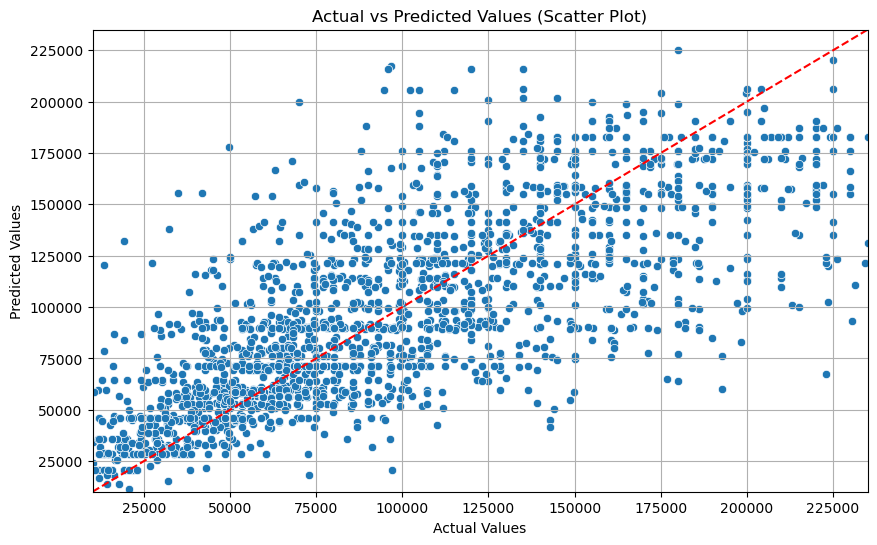

In [555]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred_reduced)
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         color='red', linestyle='--')  # Diagonal line for reference
plt.title('Actual vs Predicted Values (Scatter Plot)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())
plt.grid(True)
plt.show()

### RandomForest

In [557]:

corr_matrix = X_train.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.6 (or another threshold)
to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]

# Drop highly correlated features from the training and test sets
X_train_reduced = X_train.drop(to_drop, axis=1)
X_test_reduced = X_test.drop(to_drop, axis=1)

# Step 1: Define the hyperparameter distribution for RandomForestRegressor
param_dist = {
    'n_estimators': [100, 200, 300],        # Number of trees in the forest
    'max_depth': [10, 20, 30],              # Max depth of the tree (None for no limit)
    'min_samples_split': [2, 5, 10],        # Min samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],          # Min samples required at a leaf node
    'max_features': [None, 'auto', 'sqrt']  # Max features to consider for split
}

# Step 2: Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Step 3: Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, 
                                   param_distributions=param_dist, 
                                   n_iter=10,            # Number of parameter settings sampled
                                   cv=3,                 # 3-fold cross-validation
                                   n_jobs=-1,            # Use all processors
                                   random_state=42, 
                                   verbose=1)

# Step 4: Fit the model on the reduced training data with hyperparameter tuning
random_search.fit(X_train_reduced, y_train)

# Step 5: Extract the best model and hyperparameters
best_rf_model = random_search.best_estimator_
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

# Step 6: Evaluate the tuned model on the reduced training and test sets
train_r2 = best_rf_model.score(X_train_reduced, y_train)
test_r2 = best_rf_model.score(X_test_reduced, y_test)

# Predictions for reduced training and test sets
y_train_pred = best_rf_model.predict(X_train_reduced)
y_test_pred = best_rf_model.predict(X_test_reduced)

# Calculate MSE, RMSE, and MAE for reduced training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Calculate MSE, RMSE, and MAE for reduced test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print the results
print(f"Random Forest model R² on reduced training set: {train_r2:.2f}")
print(f"Random Forest model R² on reduced test set: {test_r2:.2f}")

print(f"Random Forest model MSE on reduced training set: {train_mse:.2f}")
print(f"Random Forest model MSE on reduced test set: {test_mse:.2f}")

print(f"Random Forest model RMSE on reduced training set: {train_rmse:.2f}")
print(f"Random Forest model RMSE on reduced test set: {test_rmse:.2f}")

print(f"Random Forest model MAE on reduced training set: {train_mae:.2f}")
print(f"Random Forest model MAE on reduced test set: {test_mae:.2f}")

# Step 7: Feature importance
importances = best_rf_model.feature_importances_
important_features = pd.Series(importances, index=X_train_reduced.columns).sort_values(ascending=False)

# Print the top 10 most important features
print("Top 10 Most Important Features:")
print(important_features.head(10))

print("Remaining columns in X_train after dropping highly correlated features:")
print(X_train_reduced.columns.tolist())

print("\nRemaining columns in X_test after dropping highly correlated features:")
print(X_test_reduced.columns.tolist())

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\user\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
6 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\user\anaconda3\Lib\site-packages\sklearn

Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 10}
Random Forest model R² on reduced training set: 0.75
Random Forest model R² on reduced test set: 0.65
Random Forest model MSE on reduced training set: 661852838.50
Random Forest model MSE on reduced test set: 959939453.48
Random Forest model RMSE on reduced training set: 25726.50
Random Forest model RMSE on reduced test set: 30982.89
Random Forest model MAE on reduced training set: 19117.11
Random Forest model MAE on reduced test set: 23070.89
Top 10 Most Important Features:
Country                   0.626392
YearsCodePro              0.165959
ProfessionalTech          0.052631
OpSysProfessional use     0.043263
DevType                   0.023543
WebframeHaveWorkedWith    0.017704
Industry                  0.016572
DatabaseHaveWorkedWith    0.016061
EdLevel                   0.010492
RemoteWork                0.008292
dtype: float64
Remaining columns in X_train 

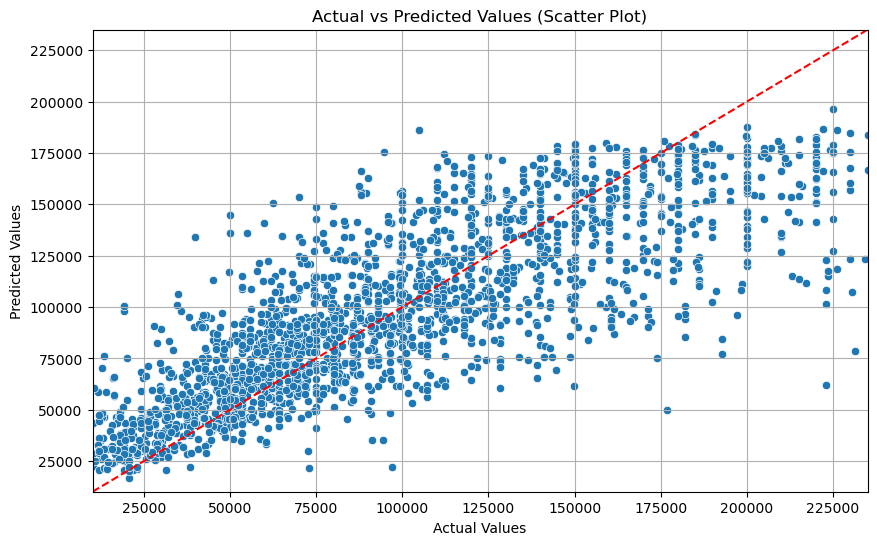

In [558]:
# Scatter plot for actual vs predicted values for the test set
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         color='red', linestyle='--')  # Diagonal line for reference
plt.title('Actual vs Predicted Values (Scatter Plot)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())
plt.grid(True)
plt.show()

### GradientBoosting

In [560]:
# Step 1: Define the hyperparameter distribution for GradientBoostingRegressor
param_dist_gb = {
    'n_estimators': [100, 200, 300],         # Number of boosting stages
    'max_depth': [3, 5, 7],                  # Maximum depth of the individual trees
    'min_samples_split': [2, 5, 10],          # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],            # Minimum number of samples required at each leaf node
    'learning_rate': [0.01, 0.05, 0.1],      # Step size shrinkage to prevent overfitting
    'subsample': [0.8, 0.9, 1.0]              # The fraction of samples to be used for fitting the individual base learners
}

# Step 2: Initialize the GradientBoostingRegressor
gb_model = GradientBoostingRegressor(random_state=42)

# Step 3: Set up RandomizedSearchCV
random_search_gb = RandomizedSearchCV(estimator=gb_model, 
                                       param_distributions=param_dist_gb, 
                                       n_iter=10,               # Number of parameter settings sampled
                                       cv=3,                    # 3-fold cross-validation
                                       n_jobs=-1,               # Use all processors
                                       random_state=42, 
                                       verbose=1)

# Step 4: Fit the model on the training data with hyperparameter tuning
random_search_gb.fit(X_train, y_train)

# Step 5: Extract the best model and hyperparameters
best_gb_model = random_search_gb.best_estimator_
best_params_gb = random_search_gb.best_params_
print(f"Best Parameters for Gradient Boosting: {best_params_gb}")

# Step 6: Evaluate the tuned model on the training and test sets
train_r2_gb = best_gb_model.score(X_train, y_train)
test_r2_gb = best_gb_model.score(X_test, y_test)

# Predictions for training and test sets
y_train_pred_gb = best_gb_model.predict(X_train)
y_test_pred_gb = best_gb_model.predict(X_test)

# Calculate MSE, RMSE, and MAE for training set
train_mse_gb = mean_squared_error(y_train, y_train_pred_gb)
train_rmse_gb = np.sqrt(train_mse_gb)
train_mae_gb = mean_absolute_error(y_train, y_train_pred_gb)

# Calculate MSE, RMSE, and MAE for test set
test_mse_gb = mean_squared_error(y_test, y_test_pred_gb)
test_rmse_gb = np.sqrt(test_mse_gb)
test_mae_gb = mean_absolute_error(y_test, y_test_pred_gb)

# Print the results
print(f"Gradient Boosting model R² on training set: {train_r2_gb:.2f}")
print(f"Gradient Boosting model R² on test set: {test_r2_gb:.2f}")

print(f"Gradient Boosting model MSE on training set: {train_mse_gb:.2f}")
print(f"Gradient Boosting model MSE on test set: {test_mse_gb:.2f}")

print(f"Gradient Boosting model RMSE on training set: {train_rmse_gb:.2f}")
print(f"Gradient Boosting model RMSE on test set: {test_rmse_gb:.2f}")

print(f"Gradient Boosting model MAE on training set: {train_mae_gb:.2f}")
print(f"Gradient Boosting model MAE on test set: {test_mae_gb:.2f}")

# Feature importance
importances_gb = best_gb_model.feature_importances_
important_features_gb = pd.Series(importances_gb, index=X_train.columns).sort_values(ascending=False)

# Print the top 10 most important features
print("Top 10 Most Important Features for Gradient Boosting:")
print(important_features_gb.head(10))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for Gradient Boosting: {'subsample': 0.9, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.05}
Gradient Boosting model R² on training set: 0.77
Gradient Boosting model R² on test set: 0.68
Gradient Boosting model MSE on training set: 628191287.59
Gradient Boosting model MSE on test set: 869915179.67
Gradient Boosting model RMSE on training set: 25063.74
Gradient Boosting model RMSE on test set: 29494.32
Gradient Boosting model MAE on training set: 18638.03
Gradient Boosting model MAE on test set: 21846.87
Top 10 Most Important Features for Gradient Boosting:
Country                   0.608294
YearsCodePro              0.117854
ProfessionalTech          0.060736
WorkExp                   0.051428
OpSysProfessional use     0.040042
DevType                   0.028253
DatabaseHaveWorkedWith    0.016569
WebframeHaveWorkedWith    0.015322
Industry                

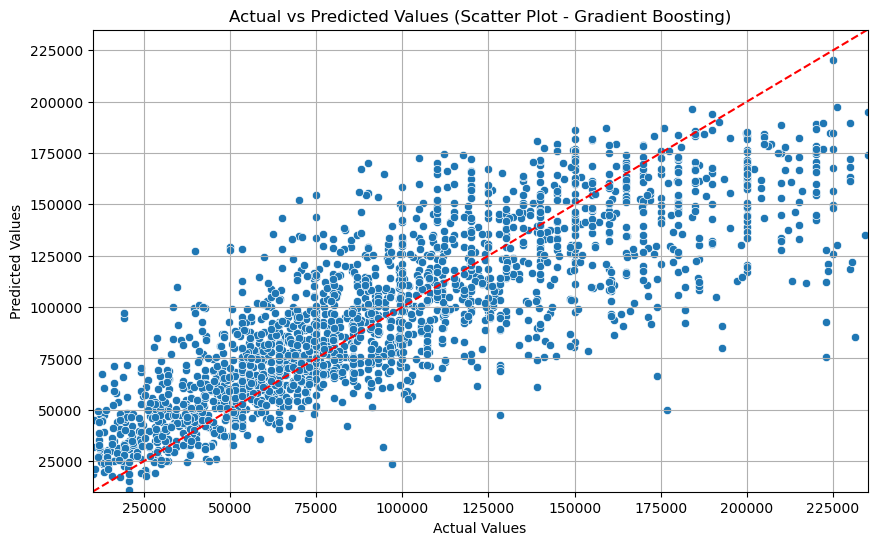

In [561]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred_gb)
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         color='red', linestyle='--')  # Diagonal line for reference
plt.title('Actual vs Predicted Values (Scatter Plot - Gradient Boosting)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())
plt.grid(True)
plt.show()

In [562]:
used_features = X_train.columns.tolist()
print("Features used in the model:")
print(used_features)

Features used in the model:
['Country', 'YearsCodePro', 'WorkExp', 'OpSysProfessional use', 'ProfessionalTech', 'DevType', 'Industry', 'EdLevel', 'Age', 'LanguageHaveWorkedWith', 'RemoteWork', 'Employment', 'ToolsTechHaveWorkedWith', 'DatabaseHaveWorkedWith', 'WebframeHaveWorkedWith']


In [563]:
model_filename = r'C:\\Users\\user\\OneDrive - Sri Lanka Institute of Information Technology\\Desktop\\SalPred\\SalaryPred\\best__model.pkl'
features_filename = r'C:\\Users\\user\\OneDrive - Sri Lanka Institute of Information Technology\\Desktop\\SalPred\\SalaryPred\\used_features.pkl'
# Save the model
with open(model_filename, 'wb') as model_file:
    pickle.dump(best_gb_model, model_file)

# Save the features used
with open(features_filename, 'wb') as features_file:
    pickle.dump(used_features, features_file)

print(f"Model and features saved to: {model_filename} and {features_filename}")

Model and features saved to: C:\\Users\\user\\OneDrive - Sri Lanka Institute of Information Technology\\Desktop\\SalPred\\SalaryPred\\best__model.pkl and C:\\Users\\user\\OneDrive - Sri Lanka Institute of Information Technology\\Desktop\\SalPred\\SalaryPred\\used_features.pkl
